In [138]:
from astropy.io import fits
from astropy import wcs
import bz2
import os
import urllib.request
import numpy as np
import copy
import matplotlib.pyplot as plt
import csv
from astropy.utils.data import get_pkg_data_filename
from matplotlib.colors import LogNorm

In [185]:
def fileasymmetry(filename, r, rowf=101, colf=101, FITS_directory='Downloads/allison/'):
    #Returns an array of the fourier A1 parameter and the phase angle for a given object filename
    #r= Array of Radiuss to probe (in pixels) to calculate the fourier coefficient for
    #expAB= The ratio of the semi major axes of the disk
    # Run, rerun, camcol, field = Specified the SDSS field the object is contained in
    # rowf, colf = the pixel coordinates of the centre of the image, in FITS coordinates (ie, first pixel is 1, not zero) 
    # FITS_directory=Location of folder of fits files
    #Open FITS file from disk

    file=fits.open(FITS_directory+filename)
 
    image=file[0] 
    data=image.data
    output=[]
    
    #If user has entered single radius, converts this to list so can be iterated over later
    if type(r)==float or type(r)==int:
        r=[r]
    #Convert centre row and column to python convention (starting at zero), instead of FITS convention(starting at 1)
    rowc=rowf-1
    colc=colf-1
   
    
    
    #Create an array of theta values to sample the ellipse at
    dtheta=360./360.
    thetas=np.arange(0,360,dtheta)
    thetarad=[i*2*np.pi/360. for i in thetas]
    for relement in r: 
        #Get semi-major and semi-minor axes of the ellipse to calculate the fourier coefficients around. In arcsec
        #Create array with data values for each theta, r combination
        pixbrightness=[]
        for i in range(len(thetas)):
            #Calculate ra, dec values of target
            #First calculate distances from centre
            dx=relement*np.sin(thetarad[i])
            dy=relement*np.cos(thetarad[i])
            #Then add on coordinates of centre
            x=int(round(colc+dx))
            y=int(round(rowc+dy))
            pixbrightness.append(data[y, x])
            
        #Weight the pixel brightnesses by cos(theta) and sin(theta)
        brightnesssin=[pixbrightness[i]*np.sin(thetarad[i]) for i in range(len(thetarad))]
        brightnesscos=[pixbrightness[i]*np.cos(thetarad[i]) for i in range(len(thetarad))]
        #Find the a1 & b1 fourier coefficients. 1/pi * integral over pixelbrighness sin/cos (integrated using np.trapz). f(x)=ancosntheta+ bnsinntheta, summed over all n
        a1=np.pi**-1*np.trapz(brightnesscos, thetarad)
        b1=np.pi**-1*np.trapz(brightnesssin, thetarad)
        a0=np.pi**-1*np.trapz(pixbrightness, thetarad)
        #Now find fourier coefficients in the form f(x)=Ancos(ntheta-phi)
        A1=(a1**2+b1**2)**0.5
        phi=np.arctan(-a1/b1)
        output.append([A1, phi*360./2/np.pi, A1/a0, a0])
    return output
    file.close()
    
    
def a1a0filenamecsv(filename, radius, outputname):
    #Returns csv of a1/a0 for specified radii (pixels) for a csv file of filenames
    filenamelist=[]
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        #Gets data on everything except 1st row
        colnames=next(reader)
        for row in reader:
            filenamelist.append(row[0])
    #Open csvwriter for results
    with open(outputname,'w+') as outputfile:
        writer=csv.writer(outputfile)
        writer.writerow(['Filename','Petrosian Radius (pix)']+[k for k in radius])
        for i in range(len(filenamelist)):
            print(i)
            try:
                asymmetryallrs=fileasymmetry(filenamelist[i], radius)
                row=[filenamelist[i]]+[findpetrorad(filenamelist[i])]+[asymmetryallrs[j][2] for j in range(len(asymmetryallrs))]
                writer.writerow(row)
            except ValueError as exc:
                print(exc)
                continue
            except IndexError as exc:
                #If galaxy is too close to the edge, get index error. In this case, just append the average value of the list so far(important for calculating averages over ranges of radii later)
                row=[ras[i],decs[i]]+[asymmetryallrs[j][2] for j in range(len(asymmetryallrs))]
                writer.writerow(row)
                print(exc)
                continue
                
def findpetrorad(filename, rowc=100, colc=100, FITS_directory='Downloads/allison/', rpinit=5):
    #Finds the petrosian radius as defined here: http://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=mag_petro
    #Initialise rp at 1 pixel. Calculate petrosian ratio. If not less than 0.2, increase rp and try again
    rp=rpinit
    file=fits.open(FITS_directory+filename)
    image=file[0] 
    data=image.data
    while True:
        top=2*(1.25**2-0.8**2)**-1*rp**-2*np.trapz([r*azimuthal_averaged_brightness(data, r, rowc, colc) for r in np.arange(0.8*rp,1.25*rp, 1)], np.arange(0.8*rp,1.25*rp, 1))
        bottom=2*rp**-2*np.trapz([r*azimuthal_averaged_brightness(data, r,colc, rowc) for r in np.arange(0,rp, 1)], np.arange(0,rp,1))
        if top/bottom<0.2:
            return rp
        else:
            rp+=1
            continue
def azimuthal_averaged_brightness(image, radius, colc, rowc):
    #Finds the azimuthally averaged intensity at a particular radius
    dtheta=360./360.
    thetas=np.arange(0,360,dtheta)
    thetarad=[i*2*np.pi/360. for i in thetas]
    pixbrightness=[]
    for i in range(len(thetarad)):
        #First calculate distances from centre
        dx=radius*np.sin(thetarad[i])
        dy=radius*np.cos(thetarad[i])
        #Then add on coordinates of centre
        x=int(round(colc+dx))
        y=int(round(rowc+dy))
        pixbrightness.append(image[y, x])
    average=(2*np.pi)**-1*np.trapz(pixbrightness, thetarad)
    return average


In [186]:
a1a0filenamecsv('List of victors simulations.csv',np.arange(1,90,1), 'victor results down 1 pix')

0


/Users/alexallison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexallison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


/Users/alexallison/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


In [181]:
def display_images_and_results(resultscsv, rowstodisplay=False, FITSdirectory='Downloads/allison/'):
    #results csv is a csv file of results and filenames
    #if rowstodisplay is included, only that subset are shown in the image
    with open(resultscsv) as csvfile:
        reader = csv.reader(csvfile)
        filenamelist=[]
        resultslist=[]
        petroradlist=[]
        #Gets data on everything except 1st row
        colnames=next(reader)
        for row in reader:
            filenamelist.append(row[0])
            petroradlist.append(row[1])
            resultslist.append(row[2:])
    if not rowstodisplay:
        #Leave all rows in
        displaylist=filenamelist[:]
        displayresults=resultslist[:]
        displaypetrorad=petroradlist[:]
    else:
        displaylist=[filenamelist[i] for i in rowstodisplay]
        displayresults=[resultslist[i] for i in rowstodisplay]
        displaypetrorad=[petroradlist[i] for i in rowstodisplay]
    subplots=plt.subplots(ncols=2,nrows=len(displaylist), figsize=(15, 7.5*len(displaylist)))
    #Go through each row
    for i in range(len(subplots[1])):
        imagefile=get_pkg_data_filename(FITSdirectory+displaylist[i])
        imagedata=fits.getdata(imagefile)
        #It doesn't handle zero's in the lognormal scaling, so add a tiny ammount to each pixel to get a black background
        for j in imagedata:
            j+=1e-5
        subplots[1][i][0].imshow(imagedata, cmap='gray', norm=LogNorm(vmin=0.1))
        subplots[1][i][1].plot([int(i) for i in colnames[2:]], [float(i) for i in displayresults[i]])
        subplots[1][i][1].set_ylim([0,1])
        subplots[1][i][1].set_xlim([5,int(float(displaypetrorad[i])*1.3)])
        
    plt.show()
        
    

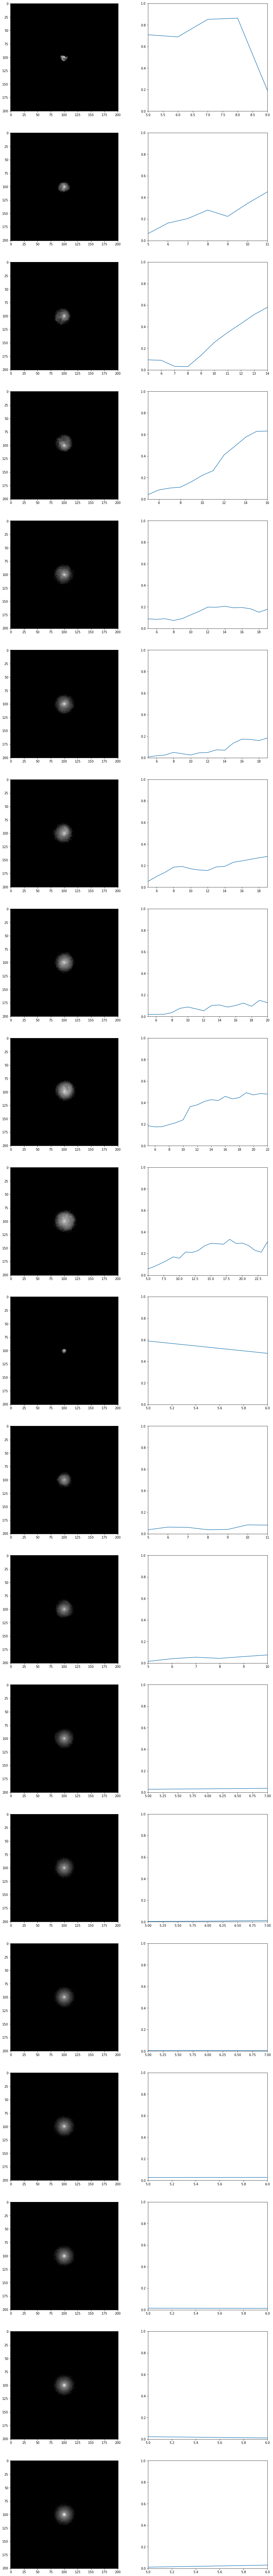

In [184]:
display_images_and_results('list of victors simulations pix.csv', rowstodisplay=range(0,200,10))